# Neural Computing Coursework
Objectives:
1. Compare the two RNN algorithms: RNN and LSTM
2. Performance comparison
3. Contrast with their advantage and disadvantages


Dataset: 10 years of S&P 500 index data
NECO Methods:
1. Recurrent Neural Network
2. LSTM

## All imports and settings

In [303]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from skorch import NeuralNetRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (10,5)

## Use of computational devices
The following block will set the devicd according to what is available. The priority has been set as **cuda** > **metal for Apple Silicon** > **cpu**

In [123]:
if torch.cuda.is_available():
  device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#   device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using device: {}".format(device))

Using device: cpu


Read the data from csv file and set the index column to **Date**

In [124]:
stock_data = pd.read_csv('sp500_index.csv', index_col='Date', parse_dates=True)
print(stock_data.head())

             S&P500
Date               
2013-03-25  1551.69
2013-03-26  1563.77
2013-03-27  1562.85
2013-03-28  1569.19
2013-04-01  1562.17


In [125]:
close = stock_data[['S&P500']]
print(close.head())

             S&P500
Date               
2013-03-25  1551.69
2013-03-26  1563.77
2013-03-27  1562.85
2013-03-28  1569.19
2013-04-01  1562.17


## First look of the Time Series Data
- The first graph shows the data plotting across time. The interval here is by day.
- The second grpah here showed the value after applying the method of differencing. 

Text(0.5, 1.0, 'Time Series Data of S&P500 index from 2013 to 2023')

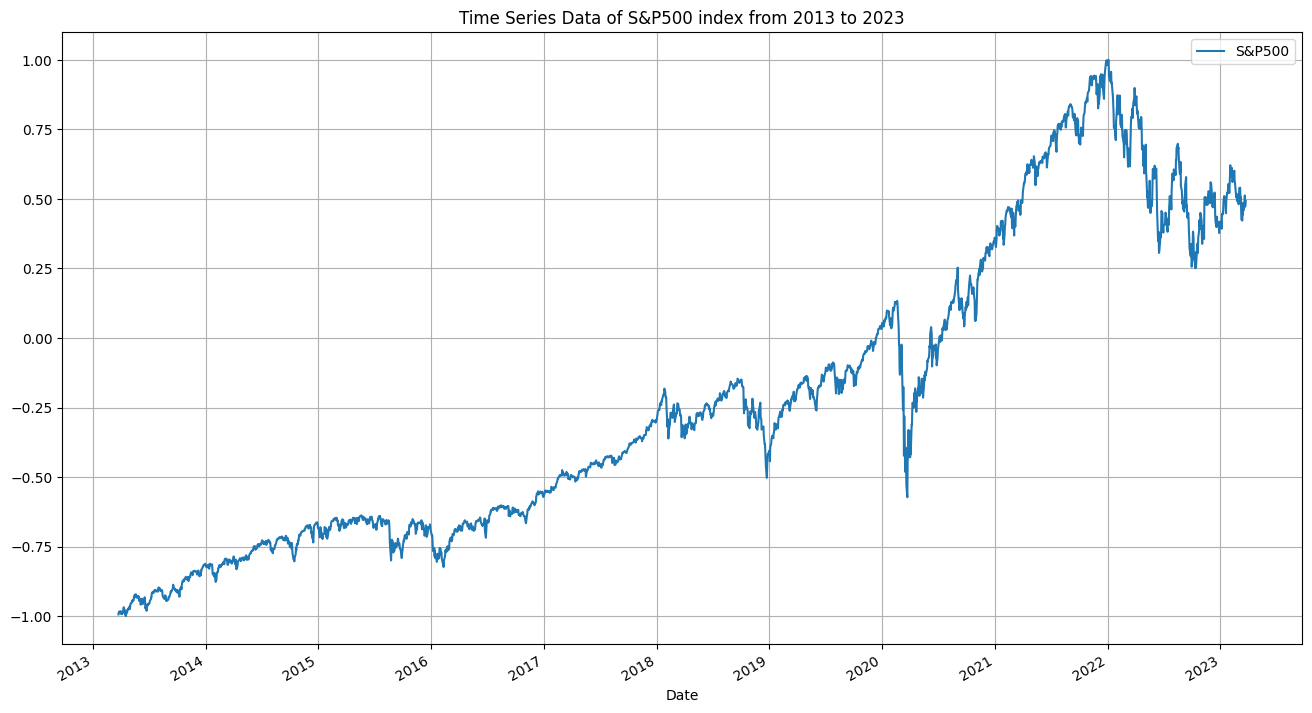

In [301]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['figure.dpi'] = 100
stock_data.plot(y='S&P500')
plt.grid('on')
plt.title("Time Series Data of S&P500 index from 2013 to 2023")

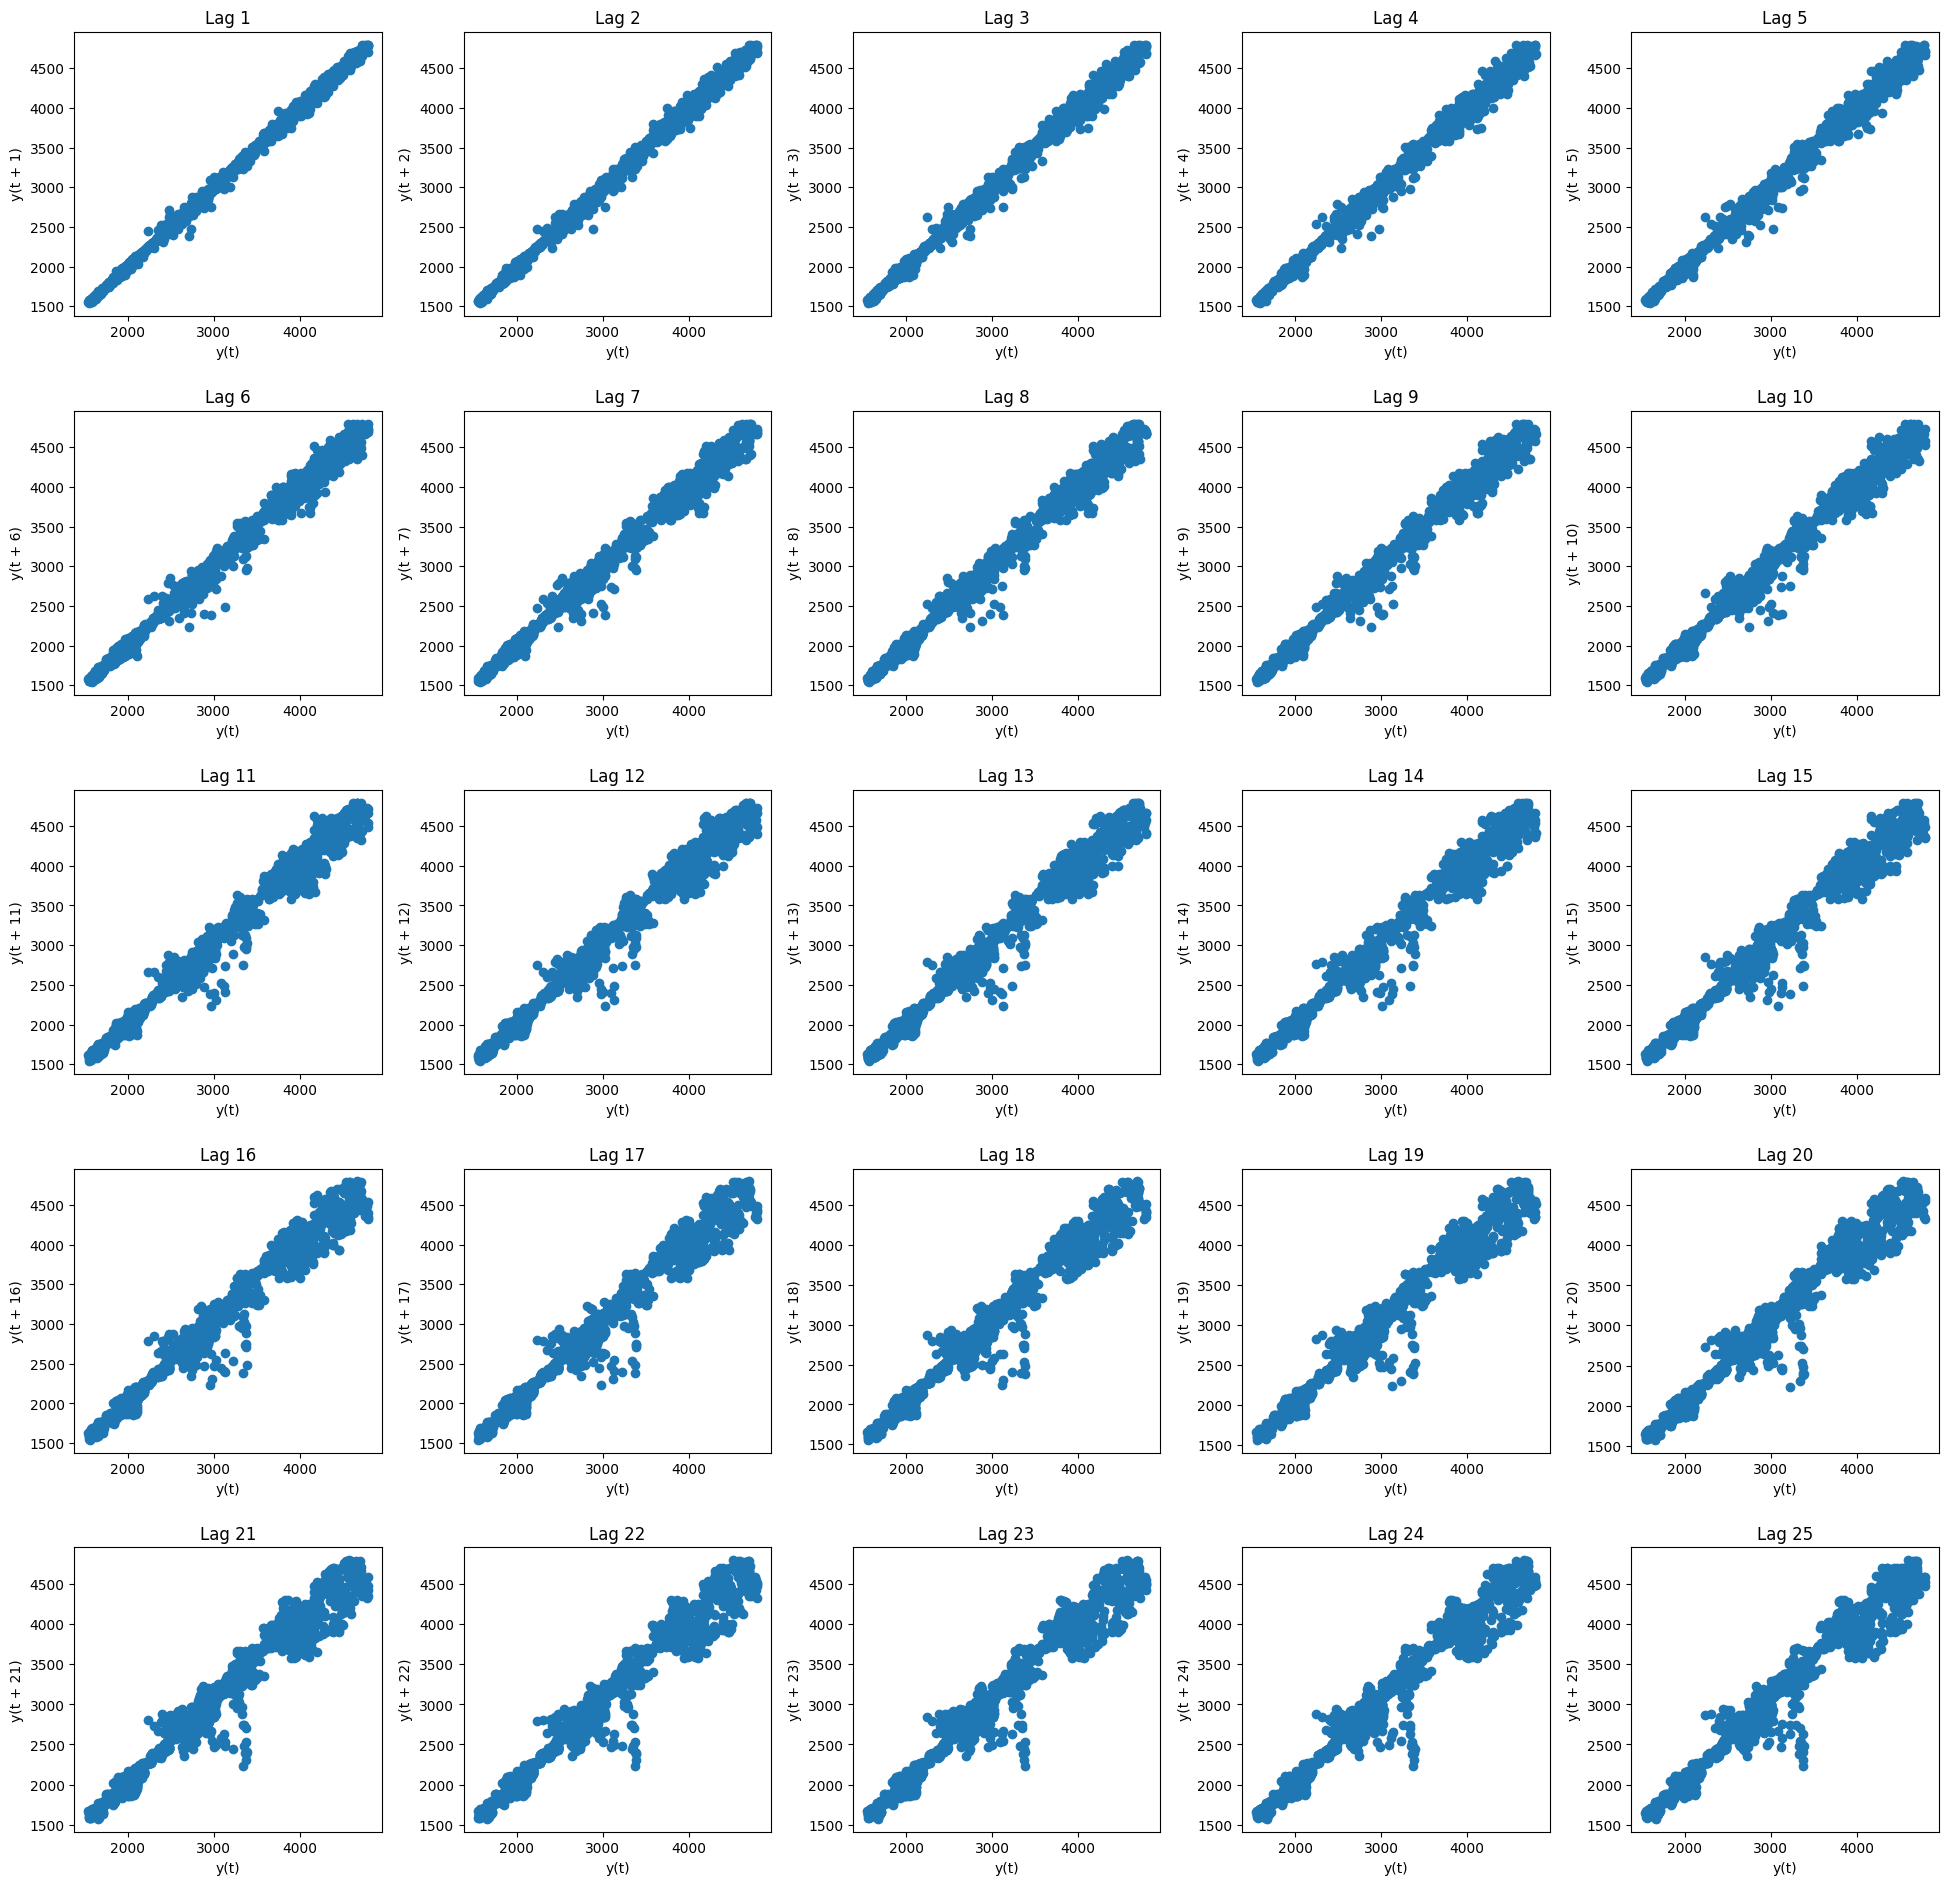

In [127]:
fig, ax = plt.subplots(5, 5)
# plt.figure(figsize=(10, 10))
plt.tight_layout()
col = 0
row = 0
while row<25:
    pd.plotting.lag_plot(stock_data['S&P500'], lag=row+1, ax=ax[col][row%5])
    ax[col][row%5].set_title("Lag {}".format(row+1))
    row += 1
    if row%5 == 0:
        col += 1

plt.subplots_adjust(top=5, bottom=3, right=1.2)


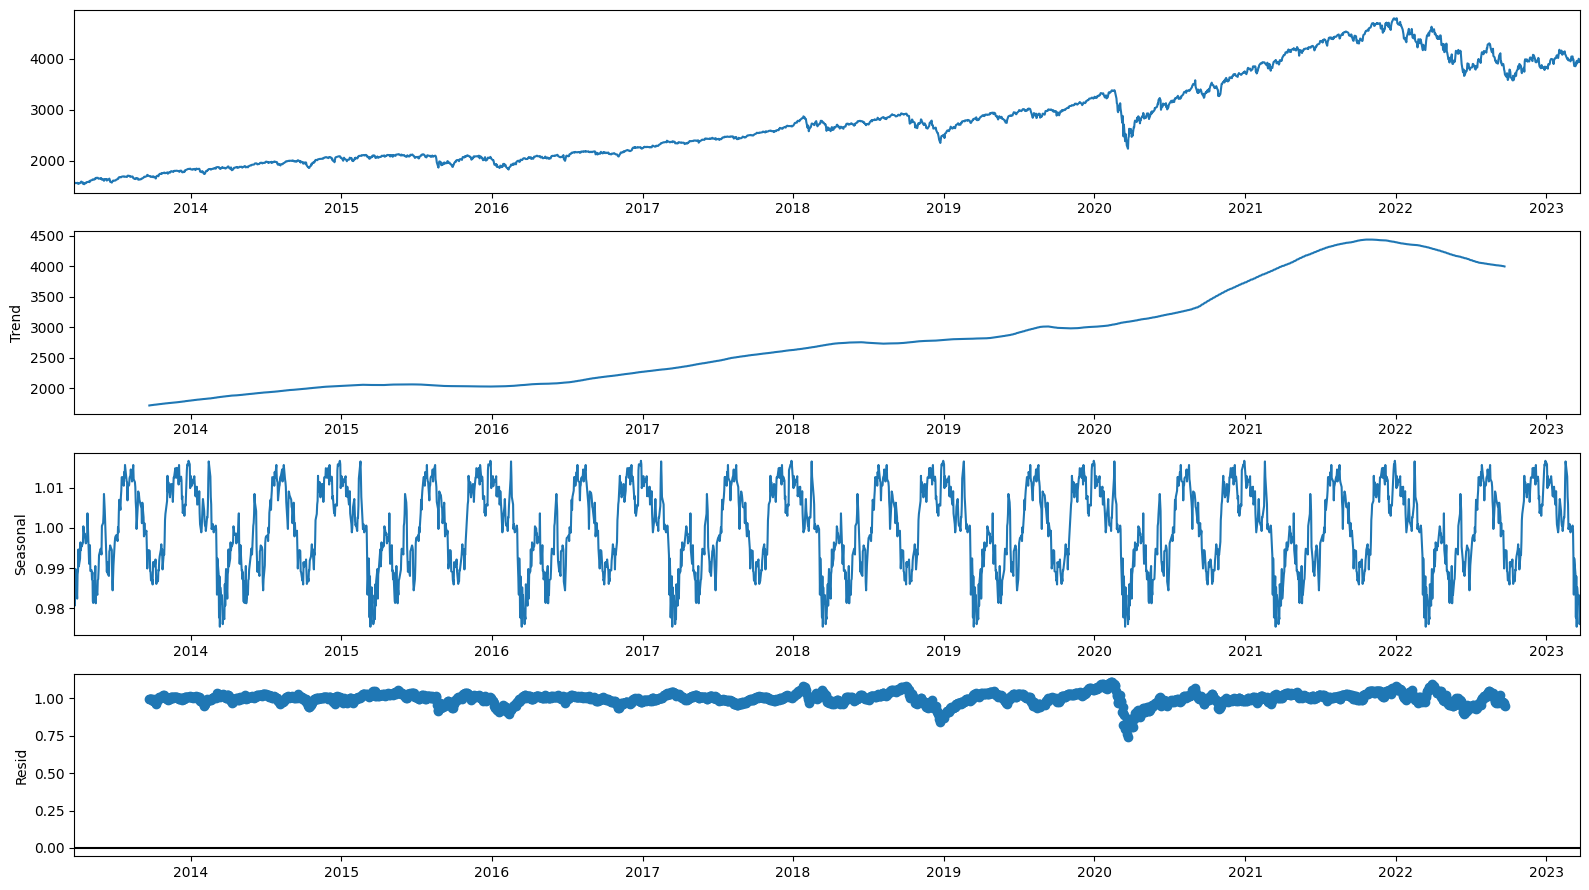

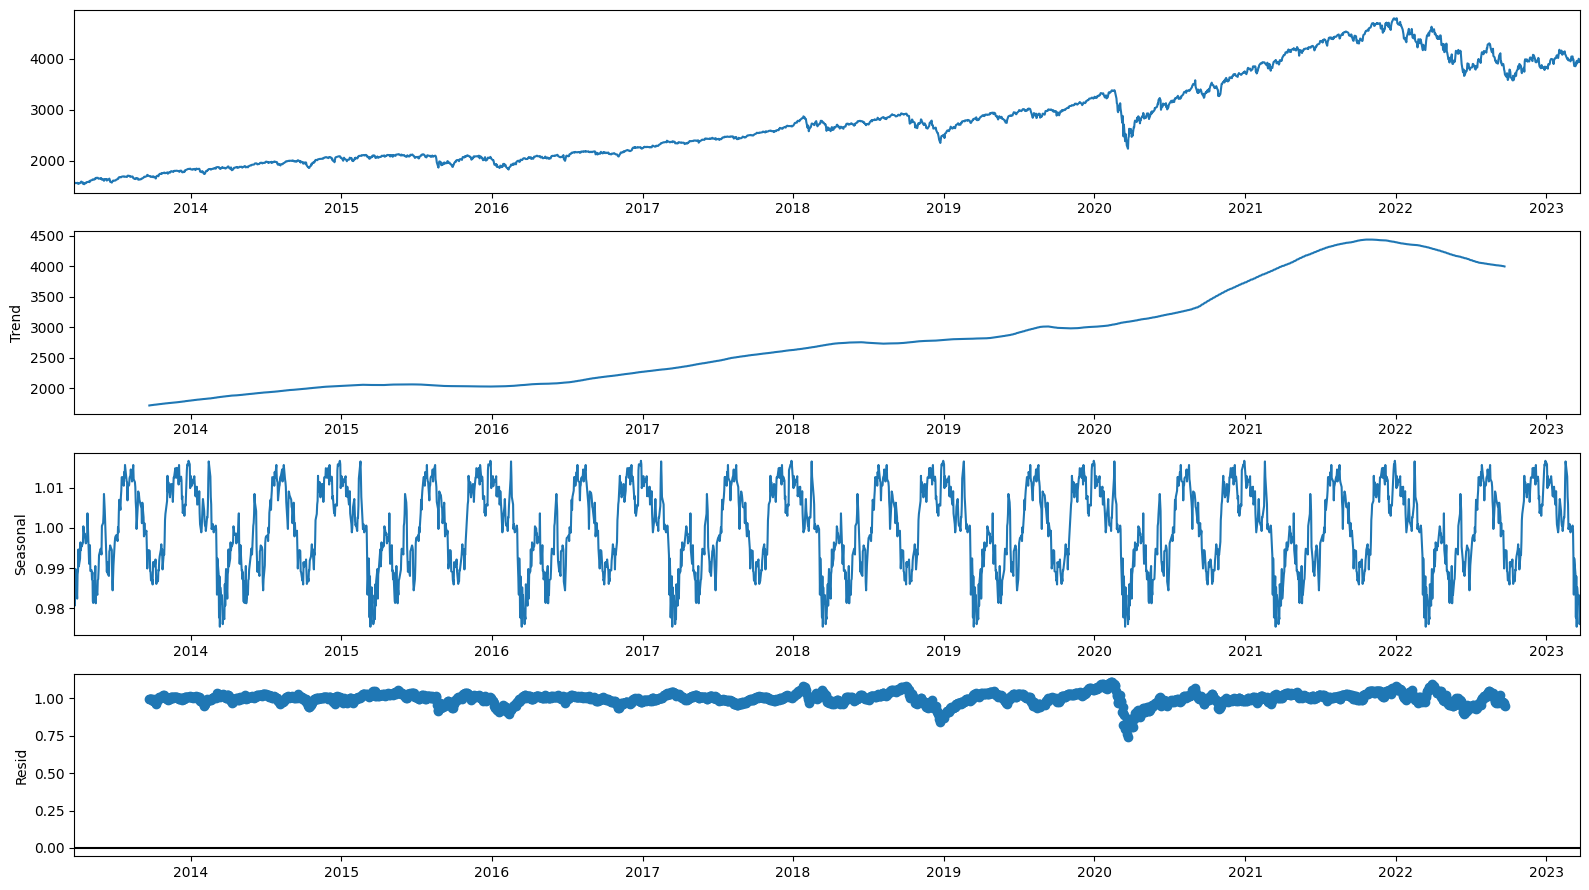

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = stock_data
decomposition_result = seasonal_decompose(series,period=252, model='multiplicative')
decomposition_result.plot()

Text(10, 4650, 'RMSE: 0.18048130238165827')

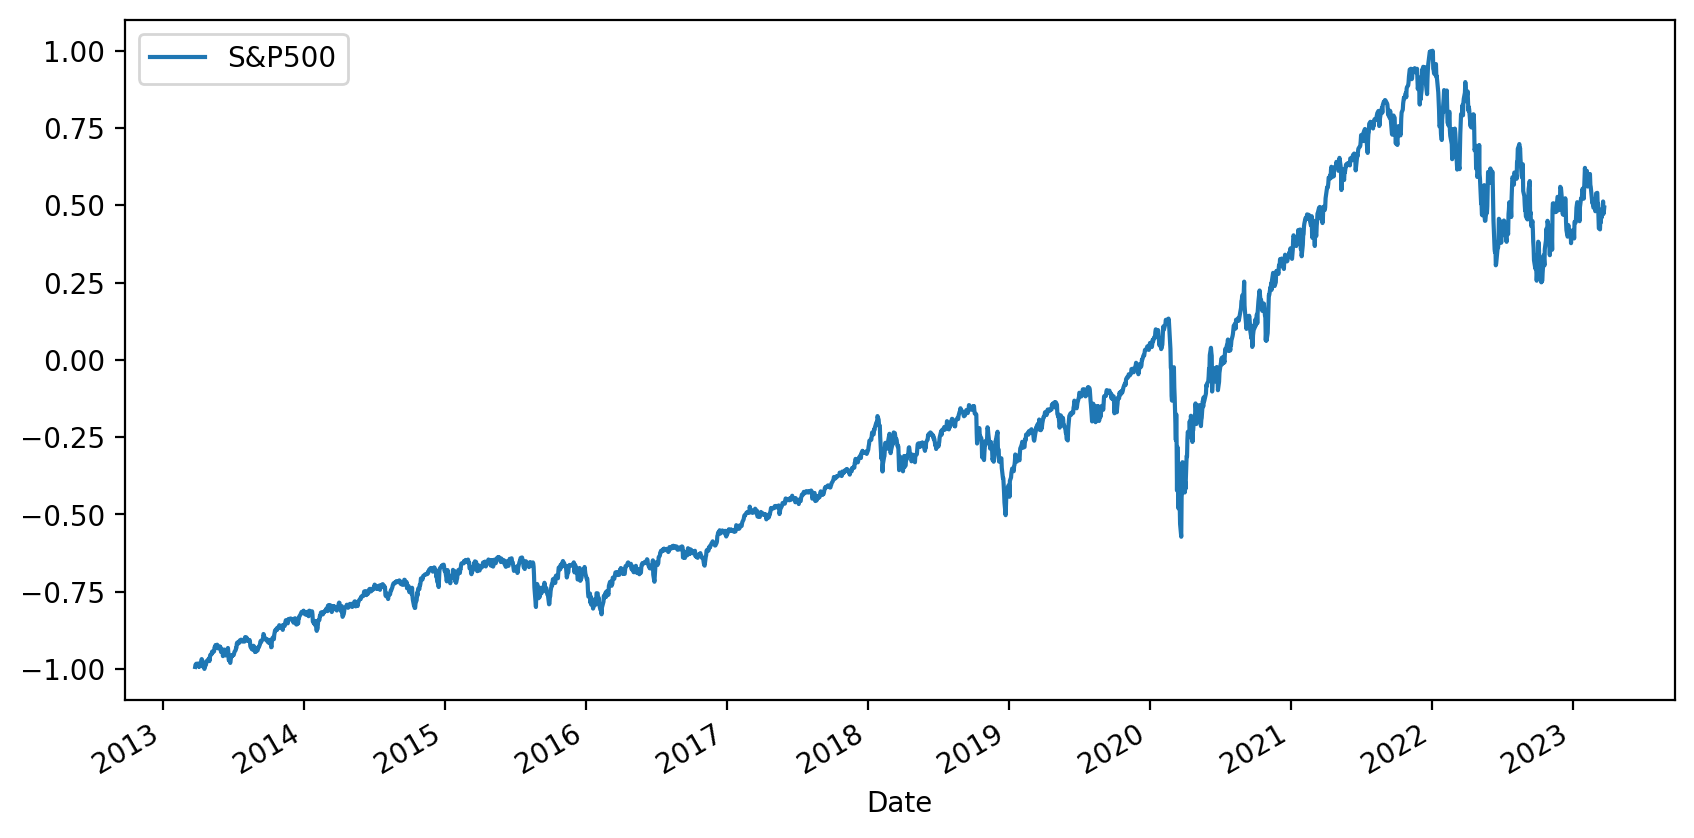

In [304]:
x = stock_data[['S&P500']].values
time = np.linspace(0, len(x), len(x)).reshape(-1, 1)

trend = LinearRegression()
trend.fit(time, x)
x_trend = trend.predict(time)
stock_data.plot(kind='line', y='S&P500')
# plt.plot(x_trend)

plt.legend(['S&P500', 'Trend Component'])
plt.annotate('R2-Score: {}'.format(r2_score(x, x_trend)), xy=(10, 4750))
plt.annotate('RMSE: {}'.format(np.sqrt(mean_squared_error(x_trend, x))), xy=(10, 4650))

In [130]:
close_data = close['S&P500'].values.astype('float32')

In [131]:
stock_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
S&P500,2519.0,2798.487249,872.013018,1541.61,2068.56,2651.07,3387.965,4796.56


## Dataset preparation

The range of the time series differs more than 3000 considering the maxima and minima. Therefore, it is better to have the dataset normalized with min-max scaling. Here the data are normalized into a range from -1 to +1.

In [162]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
stock_data['S&P500'] = scaler.fit_transform(stock_data['S&P500'].values.reshape(-1, 1))
stock_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
S&P500,2519.0,-0.227713,0.535807,-1.0,-0.676216,-0.318294,0.134491,1.0


In [252]:
def create_dataset(seq, window_size):
    x = []
    y = []
    for i in range(len(seq) - window_size):
        # windows are the training features
        window = seq[i : i+ window_size]
        # The RNN is many-to-many architecture, therefore the output size 
        label = seq[i + window_size: i + window_size + 1]
        x.append(window)
        y.append(label)

    # Convert to numpy array for easier indexing
    x = np.array(x)
    y = np.array(y)

    # Split data into training and testing set
    train_size = int(0.8*len(seq))
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to tensor
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

    x_train = x_train.unsqueeze(2)
    x_test = x_test.unsqueeze(2)
    # return processed data
    return x_train, x_test, y_train, y_test

lookback = 100
training_size = int(len(stock_data)*0.8)
raw_data = stock_data['S&P500'].values
train_data = raw_data[:training_size]
test_data = raw_data[training_size:]

X_train, X_test, y_train, y_test = create_dataset(train_data, lookback)
# For the X_train and X_test to be used for LSTM training the size should be [1763, 12, 1] and [744, 12, 1]
print(X_train.size(), X_test.size())
# For the y_train and y_test, it should be [1763, 1, 1] and [744, 1, 1]
print(y_train.size(), y_test.size())

torch.Size([1612, 100, 1]) torch.Size([303, 100, 1])
torch.Size([1612, 1]) torch.Size([303, 1])


In [253]:
def create_testing_data(test_data, window_size):
    x = []
    y = []
    for i in range(len(test_data) - window_size):
        # windows are the training features
        window = test_data[i : i+ window_size]
        # The RNN is many-to-many architecture, therefore the output size
        label = test_data[i + window_size: i + window_size + 1]
        x.append(window)
        y.append(label)

    # Convert to numpy array for easier indexing
    x = np.array(x)
    y = np.array(y)
    x = torch.from_numpy(x).type(torch.Tensor)
    y = torch.from_numpy(y).type(torch.Tensor)
    x = x.unsqueeze(2)

    return x, y

testing_features, testing_target = create_testing_data(test_data, 100)
print(testing_features, testing_features)

tensor([[[0.4550],
         [0.4949],
         [0.4928],
         ...,
         [0.7937],
         [0.7981],
         [0.8053]],

        [[0.4949],
         [0.4928],
         [0.4851],
         ...,
         [0.7981],
         [0.8053],
         [0.7859]],

        [[0.4928],
         [0.4851],
         [0.4939],
         ...,
         [0.8053],
         [0.7859],
         [0.7565]],

        ...,

        [[0.4065],
         [0.3922],
         [0.4498],
         ...,
         [0.4593],
         [0.4808],
         [0.5123]],

        [[0.3922],
         [0.4498],
         [0.4319],
         ...,
         [0.4808],
         [0.5123],
         [0.4718]],

        [[0.4498],
         [0.4319],
         [0.4221],
         ...,
         [0.5123],
         [0.4718],
         [0.4790]]]) tensor([[[0.4550],
         [0.4949],
         [0.4928],
         ...,
         [0.7937],
         [0.7981],
         [0.8053]],

        [[0.4949],
         [0.4928],
         [0.4851],
         ...,
     

## Model Definition

### RNN

In [254]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=10, num_layers=1):
        super(RNN, self).__init__()
        self.input_dim = 1
        self.output_dim = 1
        self.num_layers = num_layers
        self.hidden_dim= hidden_dim
        self.rnn = nn.RNN(self.input_dim, hidden_dim, self.num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_dim, self.output_dim)

    def forward(self, x):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # get RNN outputs
        out, hn = self.rnn(x, h0)
        # get final output
        output = self.linear(out[:, -1, :])
        return output

### LSTM

In [255]:
class LSTM(nn.Module):
    def __init__(self,hidden_dim=10, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = 1
        self.output_dim = 1
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, self.output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1, :])
        return out

## Model Training

In [256]:
def train_model(model, optimizer):
    num_epochs = 2000
    training_loss = []
    testing_loss = []
    loss_func = nn.MSELoss()

    # Generate data for training
    X_train, X_test, y_train, y_test = create_dataset(train_data, lookback)
    # Move all the stuff to computation device
    model.to(device)
    X_train.to(device)
    y_train.to(device)
    X_test.to(device)
    y_test.to(device)
    # (n_layers, batch_size, hidden_dim)

    for epoch in range(1, num_epochs + 1):
        model.train()
        pred= model(X_train)
        train_loss = loss_func(pred, y_train)
        optimizer.zero_grad()
        train_loss.backward(retain_graph=True)
        optimizer.step()
        training_loss.append(train_loss.item())

        if epoch % 100 == 0:
            model.eval()
            y_pred = model(X_test)
            test_loss = loss_func(y_pred, y_test)
            testing_loss.append(test_loss.item())
            print("Epoch {}, Train Loss: {}, Test Loss: {}".format(epoch, train_loss.item(), test_loss.item()))

    training_history = {
        "train_loss": training_loss,
        "test_loss": testing_loss
    }
    return model, training_history

### RNN model Training

In [257]:
%%time
rnn_model_1 = RNN(hidden_dim=10, num_layers=1)
rnn_optimizer = torch.optim.Adam(rnn_model_1.parameters(), lr=0.01)
rnn_trained, rnn_history = train_model(rnn_model_1, rnn_optimizer)

Epoch 100, Train Loss: 0.00018777877266984433, Test Loss: 0.0020480304956436157
Epoch 200, Train Loss: 0.00017205718904733658, Test Loss: 0.0018944281619042158
Epoch 300, Train Loss: 0.00016411981778219342, Test Loss: 0.0018976618302986026
Epoch 400, Train Loss: 0.00015938637079671025, Test Loss: 0.0018953975522890687
Epoch 500, Train Loss: 0.00015635037561878562, Test Loss: 0.0018883245065808296
Epoch 600, Train Loss: 0.00015418021939694881, Test Loss: 0.0018768738955259323
Epoch 700, Train Loss: 0.00015244395763147622, Test Loss: 0.0018617091700434685
Epoch 800, Train Loss: 0.0001509333960711956, Test Loss: 0.001843788893893361
Epoch 900, Train Loss: 0.00014955815277062356, Test Loss: 0.00182420015335083
Epoch 1000, Train Loss: 0.000148284001625143, Test Loss: 0.0018039511051028967
Epoch 1100, Train Loss: 0.00014710024697706103, Test Loss: 0.0017838665517047048
Epoch 1200, Train Loss: 0.00014600450231228024, Test Loss: 0.001764550805091858
Epoch 1300, Train Loss: 0.000144996331073343

Text(0.5, 1.0, 'RNN baseline training Loss')

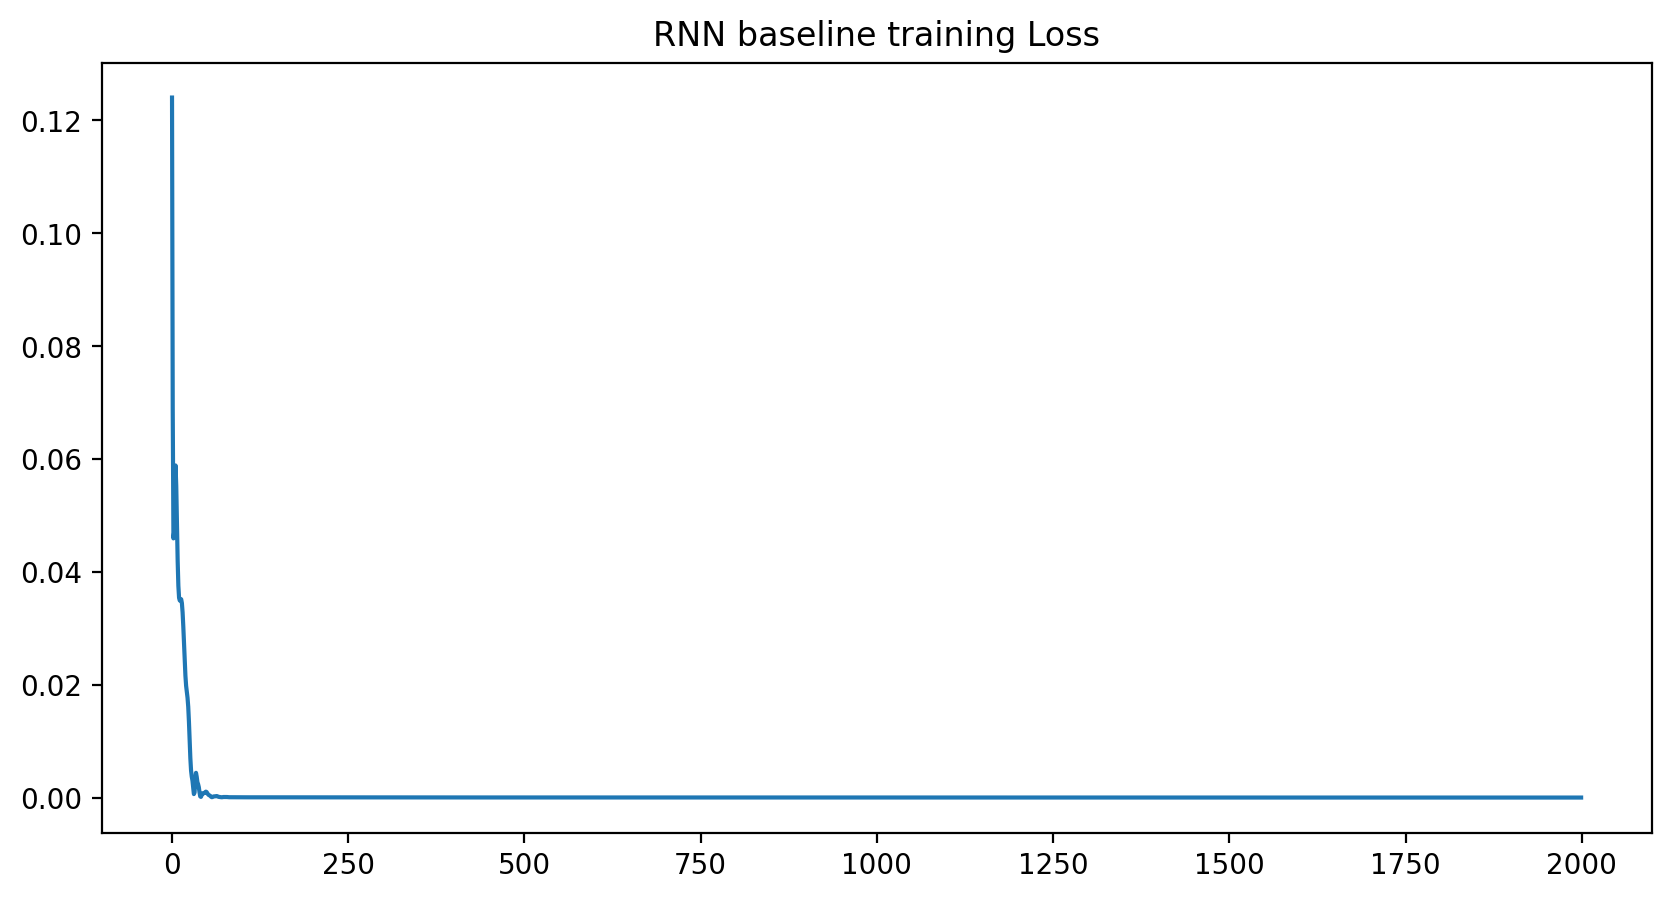

In [307]:
plt.plot(rnn_history['train_loss'])
plt.title('RNN baseline training Loss')

### LSTM model training

In [296]:
%%time
lstm_model_1 = LSTM(hidden_dim=10, num_layers=1)
lstm_optimizer = torch.optim.Adam(lstm_model_1.parameters(), lr=0.01)
lstm_trained, lstm_history = train_model(lstm_model_1, lstm_optimizer)

Epoch 100, Train Loss: 0.0004678240220528096, Test Loss: 0.03170544281601906
Epoch 200, Train Loss: 0.0002769185521174222, Test Loss: 0.011972088366746902
Epoch 300, Train Loss: 0.0002342044172110036, Test Loss: 0.005118866451084614
Epoch 400, Train Loss: 0.00021831432241015136, Test Loss: 0.002968794433400035
Epoch 500, Train Loss: 0.00020764555665664375, Test Loss: 0.002294944366440177
Epoch 600, Train Loss: 0.000198828725842759, Test Loss: 0.0020057018846273422
Epoch 700, Train Loss: 0.0001913747692015022, Test Loss: 0.0018409239128232002
Epoch 800, Train Loss: 0.00018493559036869556, Test Loss: 0.0017298993188887835
Epoch 900, Train Loss: 0.00017921744438353926, Test Loss: 0.0016459053149446845
Epoch 1000, Train Loss: 0.00017403574020136148, Test Loss: 0.0015767855802550912
Epoch 1100, Train Loss: 0.00016929337289184332, Test Loss: 0.0015169308753684163
Epoch 1200, Train Loss: 0.00016494425653945655, Test Loss: 0.0014638848369941115
Epoch 1300, Train Loss: 0.0001609690225450322, Te

Text(0.5, 1.0, 'RNN baseline testing loss')

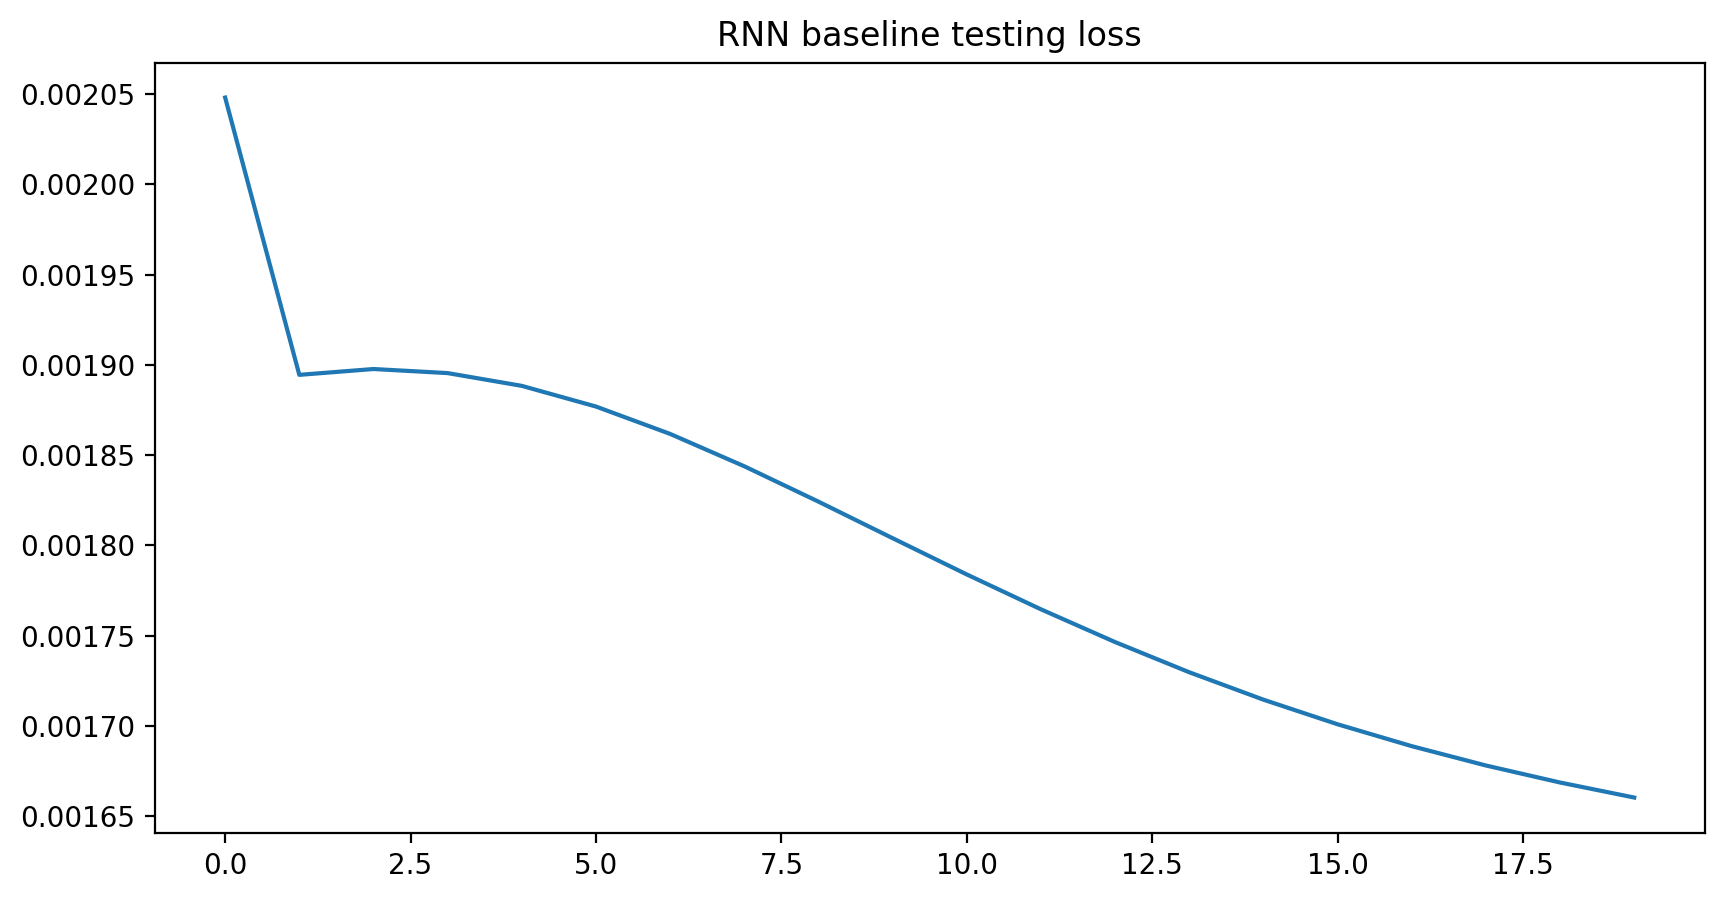

In [306]:
plt.plot(rnn_history['test_loss'])
plt.title('RNN baseline testing loss')

## Results Comparison

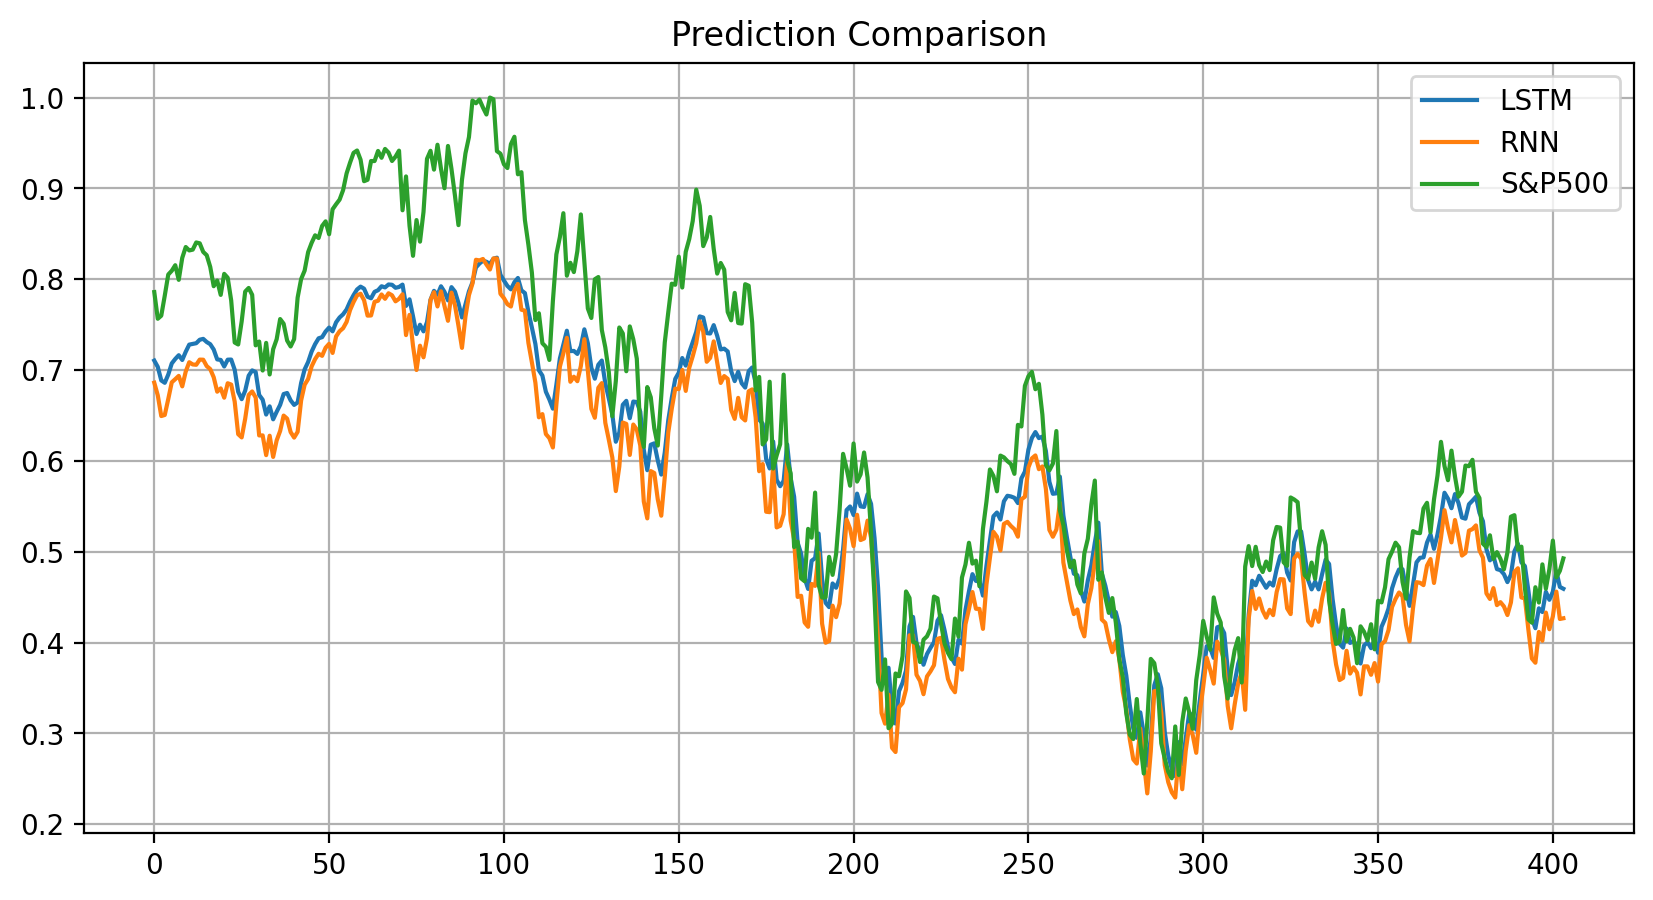

In [331]:
def visualize_prediction(lstm=lstm_trained, rnn=rnn_trained):
    lstm_pred = lstm(testing_features).cpu().detach().numpy()
    rnn_pred = rnn(testing_features).cpu().detach().numpy()
    plt.figure(figsize=(10, 5), dpi=200)
    plt.grid('on')
    plt.plot(lstm_pred)
    plt.plot(rnn_pred)
    plt.plot(testing_target.cpu().detach().numpy())
    plt.legend(['LSTM', 'RNN', 'S&P500'])
    plt.title("Prediction Comparison")
visualize_prediction(lstm_model_1, rnn_model_1)

Text(0.5, 1.0, 'Training Loss')

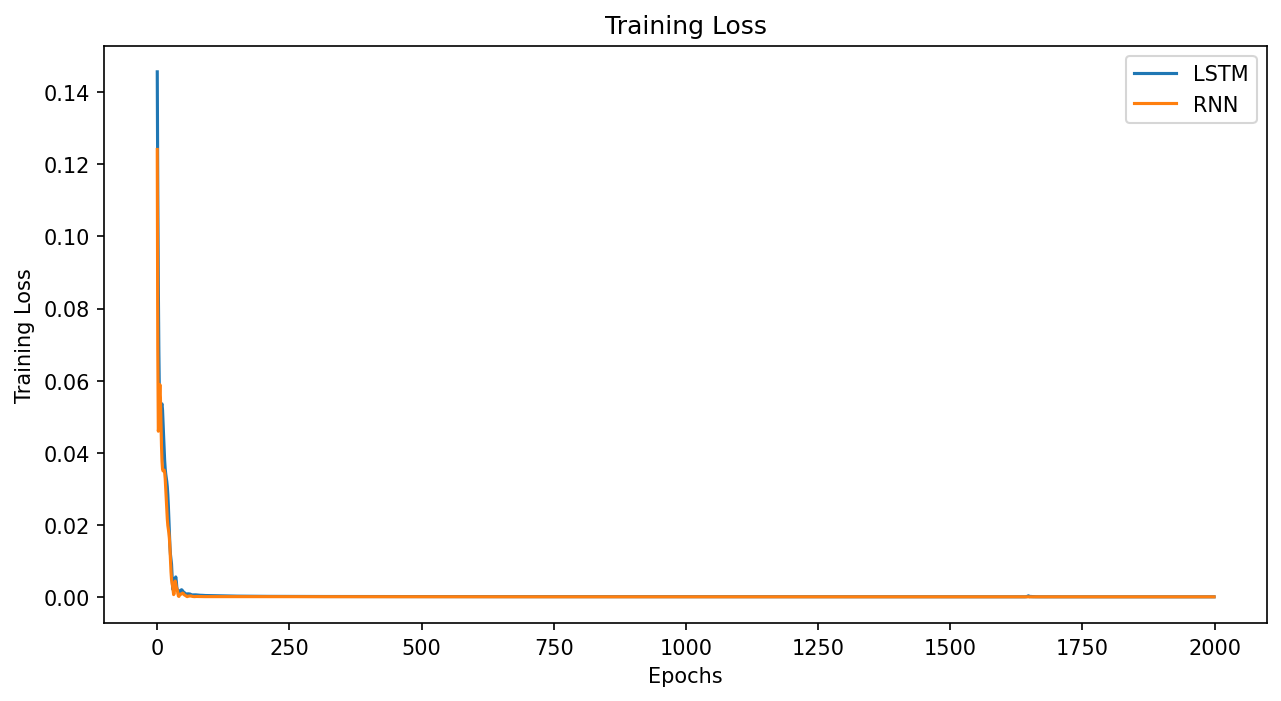

In [332]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(lstm_history['train_loss'])
plt.plot(rnn_history['train_loss'])
plt.legend(['LSTM', 'RNN'])
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.title('Training Loss')

Text(0.5, 1.0, 'Loss on the Validation Set')

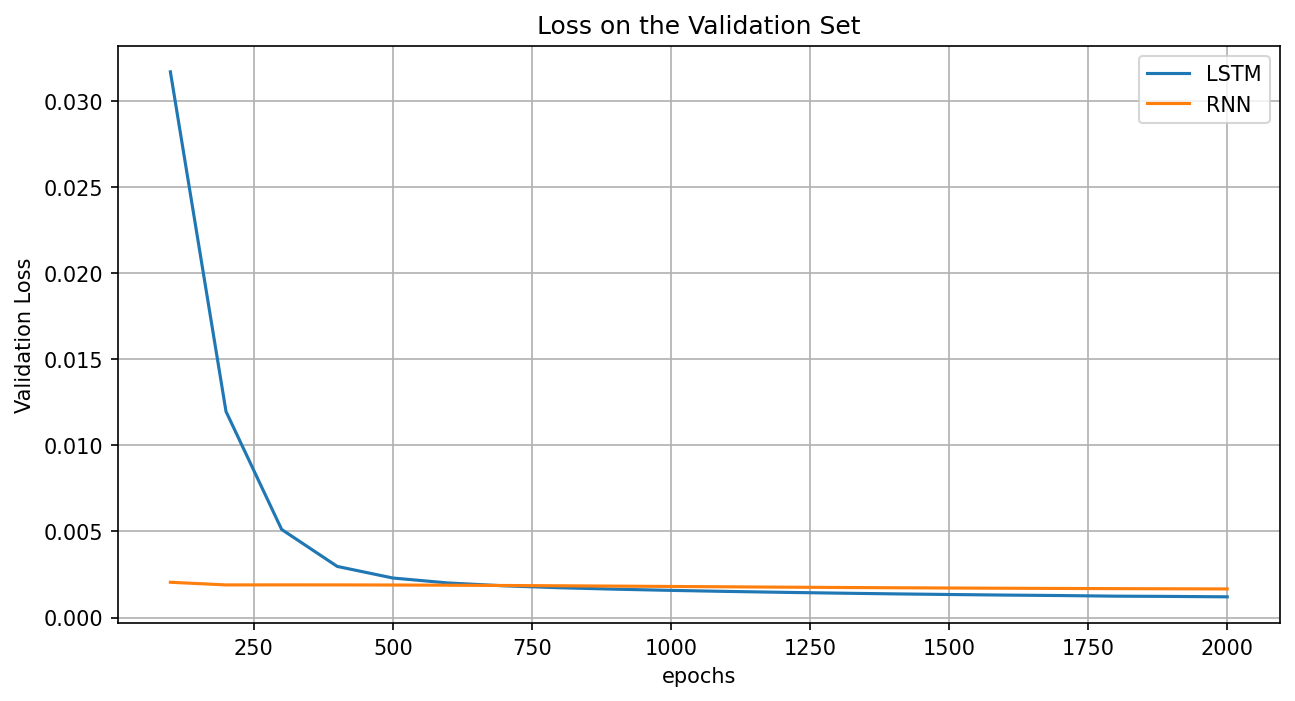

In [337]:
plt.figure(figsize=(10, 5), dpi=150)
epochs = [i*100 for i in range(1, 21)]
plt.plot(epochs, lstm_history['test_loss'])
plt.plot(epochs, rnn_history['test_loss'])
plt.ylabel('Validation Loss')
plt.xlabel('epochs')
plt.grid('on')
plt.legend(['LSTM', 'RNN'])
plt.title("Loss on the Validation Set")


In [334]:
lstm_pred = lstm_trained(testing_features).cpu().detach().numpy()
rnn_pred = rnn_trained(testing_features).cpu().detach().numpy()
print("R2_score of LSTM: {}".format(r2_score(lstm_pred, testing_target.cpu().detach().numpy())))
print("R2_score of RNN: {}".format(r2_score(rnn_pred, testing_target.cpu().detach().numpy())))

R2_score of LSTM: 0.7204739956034495
R2_score of RNN: 0.5933146007456392


In [353]:
mse_loss = nn.MSELoss()
print("LSTM Loss, MSE: {}, RMSE: {}".format(mse_loss(lstm_trained(testing_features), testing_target).detach().numpy(), np.sqrt(mse_loss(lstm_trained(testing_features), testing_target).detach().numpy())))
print("RNN Loss, MSE: {}, RMSE: {}".format(mse_loss(rnn_trained(testing_features), testing_target).detach().numpy(), np.sqrt(mse_loss(rnn_trained(testing_features), testing_target).detach().numpy())))

LSTM Loss, MSE: 0.006194004788994789, RMSE: 0.07870200276374817
RNN Loss, MSE: 0.009516983292996883, RMSE: 0.09755502641201019


## Model Optimization

In [310]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)
lstm_optimized = NeuralNetRegressor(
    LSTM,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    verbose=0,
    device=device,
    callbacks=[early_stopping]
)
rnn_optimized = NeuralNetRegressor(
    RNN,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    verbose=0,
    device=device,
    callbacks=[early_stopping]
)
X_train, X_test, y_train, y_test = create_dataset(raw_data, lookback)

# For the X_train and X_test to be used for LSTM training the size should be [1763, 12, 1] and [744, 12, 1]

param_grid = {
    'module__num_layers': [1,2,3],
    'module__hidden_dim': [10, 20, 50],
    'lr': [0.1, 0.01, 0.001]
}
lstm_grid = GridSearchCV(
    estimator=lstm_optimized,
    param_grid=param_grid,
    n_jobs=1,
    cv=3,
    scoring='neg_mean_squared_error'
)
rnn_grid = GridSearchCV(
    estimator=rnn_optimized,
    param_grid=param_grid,
    n_jobs=1,
    cv=3,
    scoring='neg_mean_squared_error'
)
lstm_grid_result = lstm_grid.fit(X_train, y_train)
rnn_grid_result  = rnn_grid.fit(X_train, y_train)

In [336]:
result = pd.DataFrame(lstm_grid_result.cv_results_)
result.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_module__hidden_dim,param_module__num_layers,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,1.581634,0.030485,0.042556,0.000981,0.01,20,1,"{'lr': 0.01, 'module__hidden_dim': 20, 'module...",-0.018083,-0.000719,-0.066282,-0.028361,0.027735,1
16,5.812397,0.045714,0.174857,0.008219,0.01,50,2,"{'lr': 0.01, 'module__hidden_dim': 50, 'module...",-0.066704,-0.013424,-0.130207,-0.070112,0.047737,2
6,2.861312,0.085727,0.083942,0.000779,0.1,50,1,"{'lr': 0.1, 'module__hidden_dim': 50, 'module_...",-0.027752,-0.048737,-0.190850,-0.089113,0.072447,3
24,2.835557,0.085666,0.087653,0.003206,0.001,50,1,"{'lr': 0.001, 'module__hidden_dim': 50, 'modul...",-0.064220,-0.001211,-0.211299,-0.092243,0.088027,4
13,3.028329,0.072038,0.079693,0.001672,0.01,20,2,"{'lr': 0.01, 'module__hidden_dim': 20, 'module...",-0.199363,-0.001370,-0.094840,-0.098524,0.080872,5
9,1.131110,0.042471,0.025211,0.000424,0.01,10,1,"{'lr': 0.01, 'module__hidden_dim': 10, 'module...",-0.056404,-0.001308,-0.252225,-0.103312,0.107673,6
22,3.070116,0.076570,0.078577,0.000382,0.001,20,2,"{'lr': 0.001, 'module__hidden_dim': 20, 'modul...",-0.067153,-0.003012,-0.251343,-0.107169,0.105255,7
10,2.192755,0.048668,0.047066,0.000655,0.01,10,2,"{'lr': 0.01, 'module__hidden_dim': 10, 'module...",-0.086742,-0.029281,-0.210422,-0.108815,0.075580,8
3,1.625635,0.038496,0.042231,0.001543,0.1,20,1,"{'lr': 0.1, 'module__hidden_dim': 20, 'module_...",-0.010125,-0.338663,-0.007250,-0.118679,0.155557,9
25,5.779670,0.055890,0.169518,0.009277,0.001,50,2,"{'lr': 0.001, 'module__hidden_dim': 50, 'modul...",-0.157930,-0.001845,-0.239919,-0.133232,0.098750,10


In [313]:
%%time
lstm_best_result = result.sort_values(by='rank_test_score').head(1)

lstm_learning_rate = float(lstm_best_result['param_lr'].values)
lstm_hidden_dim = int(lstm_best_result['param_module__hidden_dim'].values)
lstm_num_layers = int(lstm_best_result['param_module__num_layers'].values)
print("Best Parameters, learning rate = {}, hidden_dim = {}, num_layers = {}".format(lstm_learning_rate, lstm_hidden_dim, lstm_num_layers))

X_train, X_test, y_train, y_test = create_dataset(train_data, lookback)
best_lstm = LSTM(hidden_dim=lstm_hidden_dim, num_layers=lstm_num_layers)
best_lstm.to(device)
best_lstm_optimizer = torch.optim.Adam(best_lstm.parameters(), lr=lstm_learning_rate)
best_trained_lstm, best_lstm_train_history = train_model(best_lstm, best_lstm_optimizer)

Best Parameters, learning rate = 0.01, hidden_dim = 20, num_layers = 1
Epoch 100, Train Loss: 0.0003453669778537005, Test Loss: 0.01570959761738777
Epoch 200, Train Loss: 0.0002728711988311261, Test Loss: 0.00793651957064867
Epoch 300, Train Loss: 0.0002480530529282987, Test Loss: 0.004953139461576939
Epoch 400, Train Loss: 0.00023183564189821482, Test Loss: 0.0032707927748560905
Epoch 500, Train Loss: 0.00022064990480430424, Test Loss: 0.0023992254864424467
Epoch 600, Train Loss: 0.0002121334837283939, Test Loss: 0.0019829694647341967
Epoch 700, Train Loss: 0.00020496985234785825, Test Loss: 0.0017841584049165249
Epoch 800, Train Loss: 0.00019854771380778402, Test Loss: 0.0016753970412537456
Epoch 900, Train Loss: 0.0001926322147483006, Test Loss: 0.0016014116117730737
Epoch 1000, Train Loss: 0.00018711660231929272, Test Loss: 0.0015423274599015713
Epoch 1100, Train Loss: 0.0001819307217374444, Test Loss: 0.0014921759720891714
Epoch 1200, Train Loss: 0.00017702778859529644, Test Loss:

Text(0.5, 1.0, 'Test Loss')

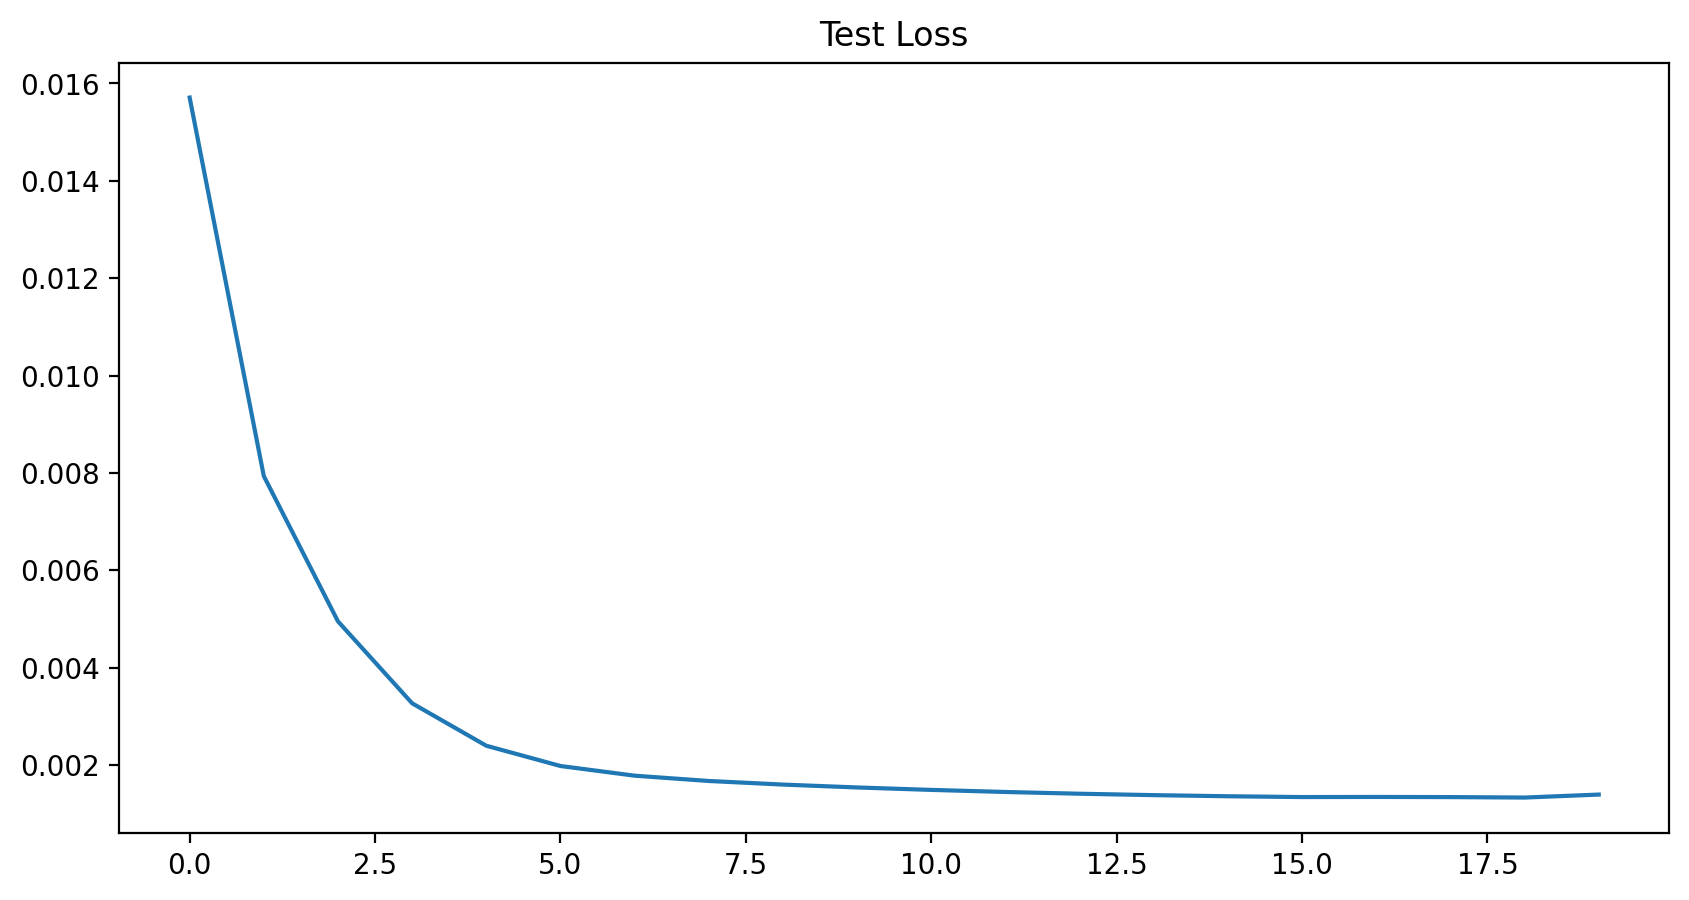

In [314]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(best_lstm_train_history['test_loss'])
plt.title('Test Loss')

Text(0.5, 1.0, 'Prediction of Optimized LSTM')

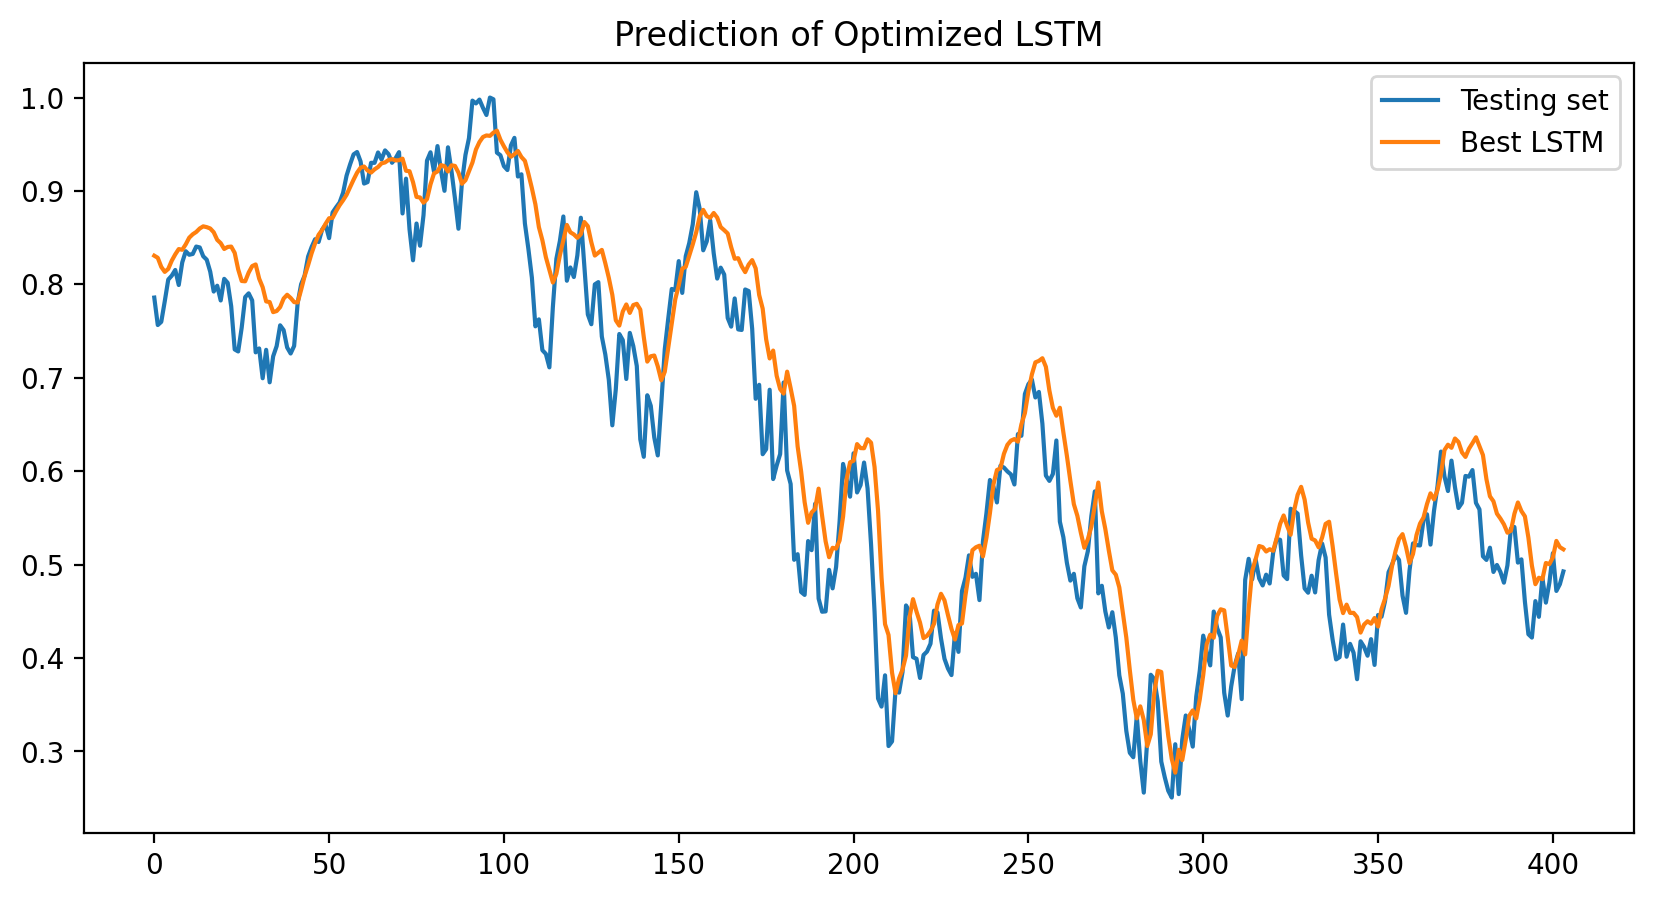

In [315]:
best_lstm_pred = best_trained_lstm(testing_features)
plt.plot(testing_target.detach().numpy())
plt.plot(best_lstm_pred.detach().numpy())
plt.legend(['Testing set', 'Best LSTM'])
plt.title('Prediction of Optimized LSTM')

In [369]:
rnn_result = pd.DataFrame(rnn_grid_result.cv_results_)
rnn_result.sort_values(by='rank_test_score', inplace=True)
rnn_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_module__hidden_dim,param_module__num_layers,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
25,1.517669,0.049358,0.042829,0.001662,0.001,50,2,"{'lr': 0.001, 'module__hidden_dim': 50, 'modul...",-0.001666,-0.002643,-0.007374,-0.003894,0.002492,1
22,0.934585,0.044401,0.022480,0.000904,0.001,20,2,"{'lr': 0.001, 'module__hidden_dim': 20, 'modul...",-0.025989,-0.003475,-0.006586,-0.012016,0.009961,2
24,0.789092,0.036518,0.022398,0.000775,0.001,50,1,"{'lr': 0.001, 'module__hidden_dim': 50, 'modul...",-0.005633,-0.000689,-0.047804,-0.018042,0.021141,3
9,0.373473,0.001056,0.008958,0.000054,0.01,10,1,"{'lr': 0.01, 'module__hidden_dim': 10, 'module...",-0.017610,-0.000204,-0.039731,-0.019182,0.016175,4
12,0.479589,0.003943,0.011959,0.000260,0.01,20,1,"{'lr': 0.01, 'module__hidden_dim': 20, 'module...",-0.011574,-0.013421,-0.065386,-0.030127,0.024943,5
13,0.920920,0.017341,0.021536,0.000315,0.01,20,2,"{'lr': 0.01, 'module__hidden_dim': 20, 'module...",-0.010011,-0.003590,-0.083208,-0.032270,0.036114,6
10,0.686893,0.002848,0.014810,0.000040,0.01,10,2,"{'lr': 0.01, 'module__hidden_dim': 10, 'module...",-0.073278,-0.004156,-0.025295,-0.034243,0.028919,7
15,0.794265,0.016176,0.022516,0.000747,0.01,50,1,"{'lr': 0.01, 'module__hidden_dim': 50, 'module...",-0.001136,-0.022585,-0.089126,-0.037616,0.037461,8
26,2.372993,0.099036,0.066715,0.004624,0.001,50,3,"{'lr': 0.001, 'module__hidden_dim': 50, 'modul...",-0.012612,-0.009922,-0.180056,-0.067530,0.079575,9
18,0.374553,0.003481,0.008830,0.000040,0.001,10,1,"{'lr': 0.001, 'module__hidden_dim': 10, 'modul...",-0.208576,-0.004477,-0.192907,-0.135320,0.092741,10


In [370]:
%%time
rnn_best_result = rnn_result.head(1)

rnn_learning_rate = float(rnn_best_result['param_lr'].values)
rnn_hidden_dim = int(rnn_best_result['param_module__hidden_dim'].values)
rnn_num_layers = int(rnn_best_result['param_module__num_layers'].values)
print("Best Parameters, learning rate = {}, hidden_dim = {}, num_layers = {}".format(rnn_learning_rate, rnn_hidden_dim, rnn_num_layers))
X_train, X_test, y_train, y_test = create_dataset(train_data, lookback)
best_rnn = RNN(hidden_dim=rnn_hidden_dim, num_layers=rnn_num_layers)
best_rnn_optimizer = torch.optim.Adam(best_rnn.parameters(), lr=rnn_learning_rate)
best_rnn.to(device)
best_trained_rnn, best_rnn_train_history = train_model(best_rnn, best_rnn_optimizer)

Best Parameters, learning rate = 0.001, hidden_dim = 50, num_layers = 2
Epoch 100, Train Loss: 0.000541473797056824, Test Loss: 0.004126504063606262
Epoch 200, Train Loss: 0.000404216640163213, Test Loss: 0.0034649132285267115
Epoch 300, Train Loss: 0.00034018472069874406, Test Loss: 0.0025791979860514402
Epoch 400, Train Loss: 0.00030091332155279815, Test Loss: 0.0021240185014903545
Epoch 500, Train Loss: 0.0002749190607573837, Test Loss: 0.0018964597256854177
Epoch 600, Train Loss: 0.00025658635422587395, Test Loss: 0.0018002998549491167
Epoch 700, Train Loss: 0.0002430184104014188, Test Loss: 0.001784103107638657
Epoch 800, Train Loss: 0.00023261093883775175, Test Loss: 0.0018133518751710653
Epoch 900, Train Loss: 0.00022436601284425706, Test Loss: 0.001857704482972622
Epoch 1000, Train Loss: 0.00021754430781584233, Test Loss: 0.0018902031006291509
Epoch 1100, Train Loss: 0.0002115679089911282, Test Loss: 0.0018953265389427543
Epoch 1200, Train Loss: 0.00020606745965778828, Test Los

Text(0.5, 1.0, 'Testing loss of final model')

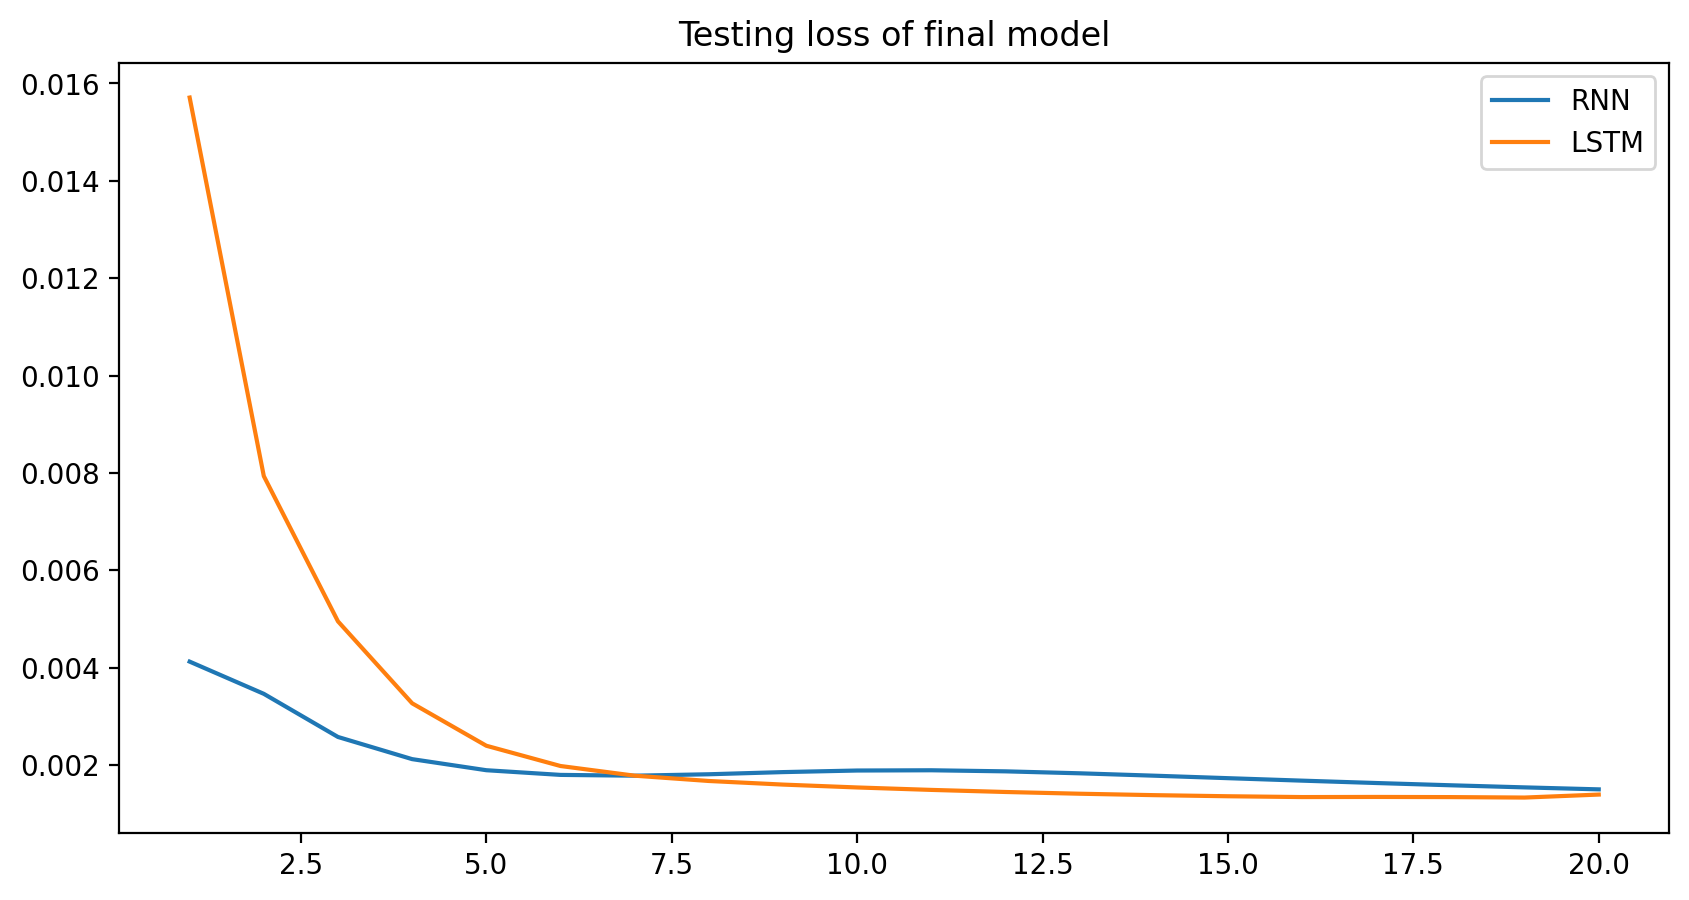

In [371]:
plt.plot(range(1, 21), best_rnn_train_history['test_loss'])
plt.plot(range(1, 21), best_lstm_train_history['test_loss'])
plt.legend(['RNN', 'LSTM'])
plt.title('Testing loss of final model')

In [372]:
best_rnn_pred = best_trained_rnn(testing_features)

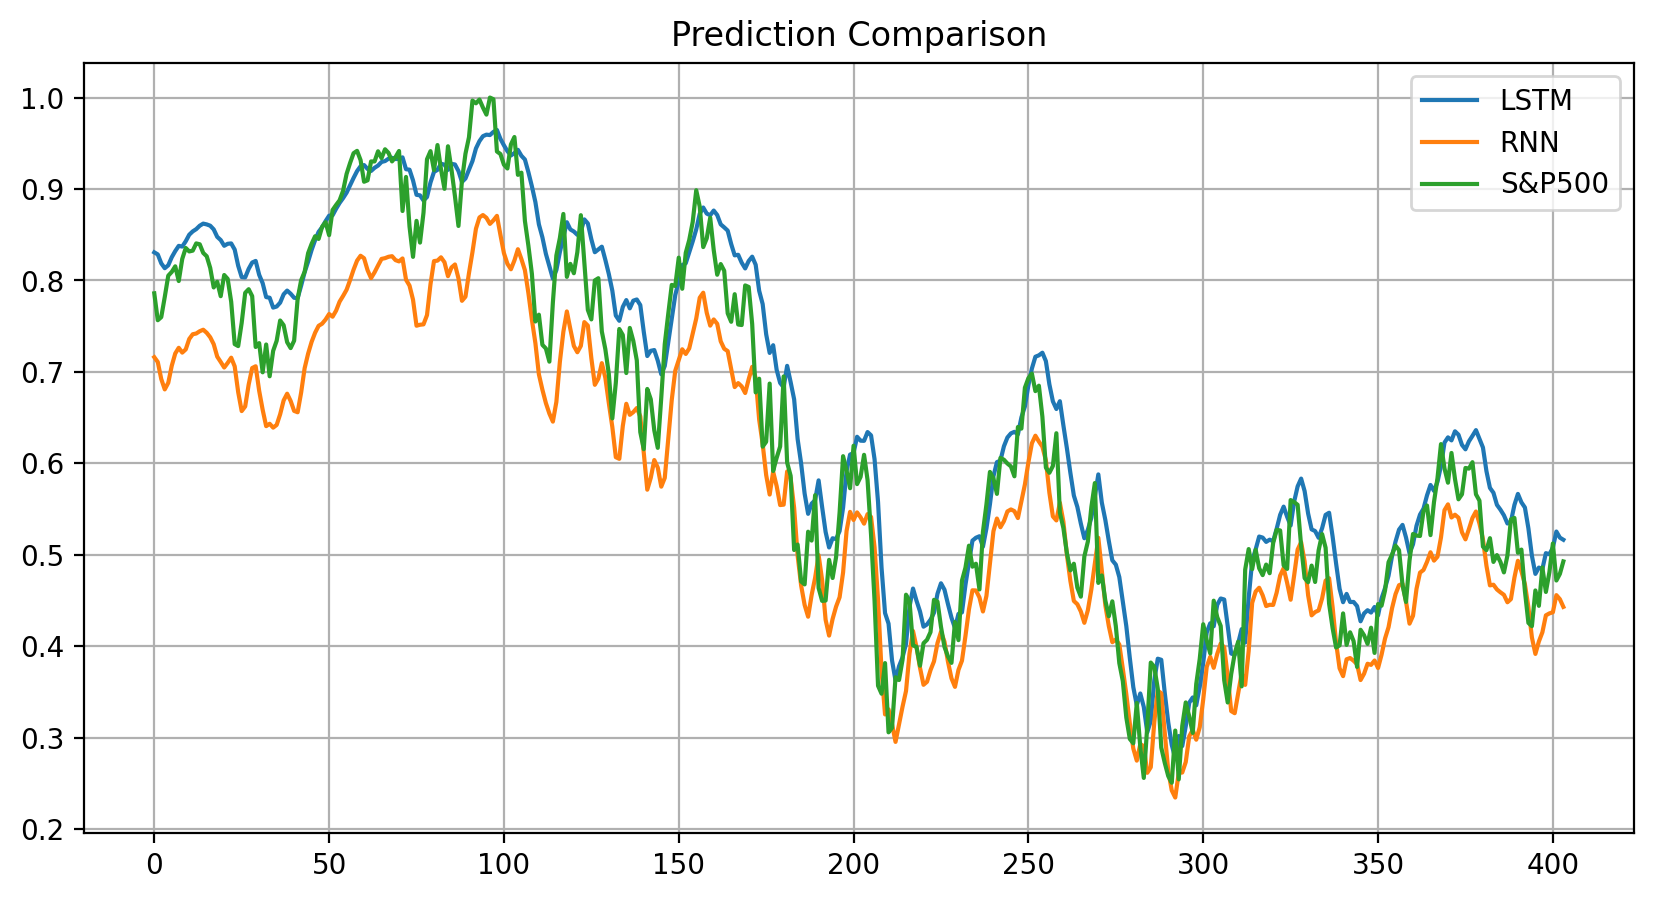

In [373]:
visualize_prediction(best_trained_lstm, best_trained_rnn)

In [374]:
print("R2_score of LSTM: {}".format(r2_score(best_trained_lstm(testing_features).detach().numpy(), testing_target.cpu().detach().numpy())))
print("R2_score of RNN: {}".format(r2_score(best_trained_rnn(testing_features).detach().numpy(), testing_target.cpu().detach().numpy())))

R2_score of LSTM: 0.9058336095648167
R2_score of RNN: 0.7863338300659095


In [376]:
mse_loss = nn.MSELoss()
print("LSTM Loss, MSE: {}, RMSE: {}".format(mse_loss(best_trained_lstm(testing_features), testing_target).detach().numpy(), np.sqrt(mse_loss(best_trained_lstm(testing_features), testing_target).detach().numpy())))
print("RNN Loss, MSE: {}, RMSE: {}".format(mse_loss(best_trained_rnn(testing_features), testing_target).detach().numpy(), np.sqrt(mse_loss(best_trained_rnn(testing_features), testing_target).detach().numpy())))

LSTM Loss, MSE: 0.0032719229348003864, RMSE: 0.05720072612166405
RNN Loss, MSE: 0.0057362159714102745, RMSE: 0.07573781162500381


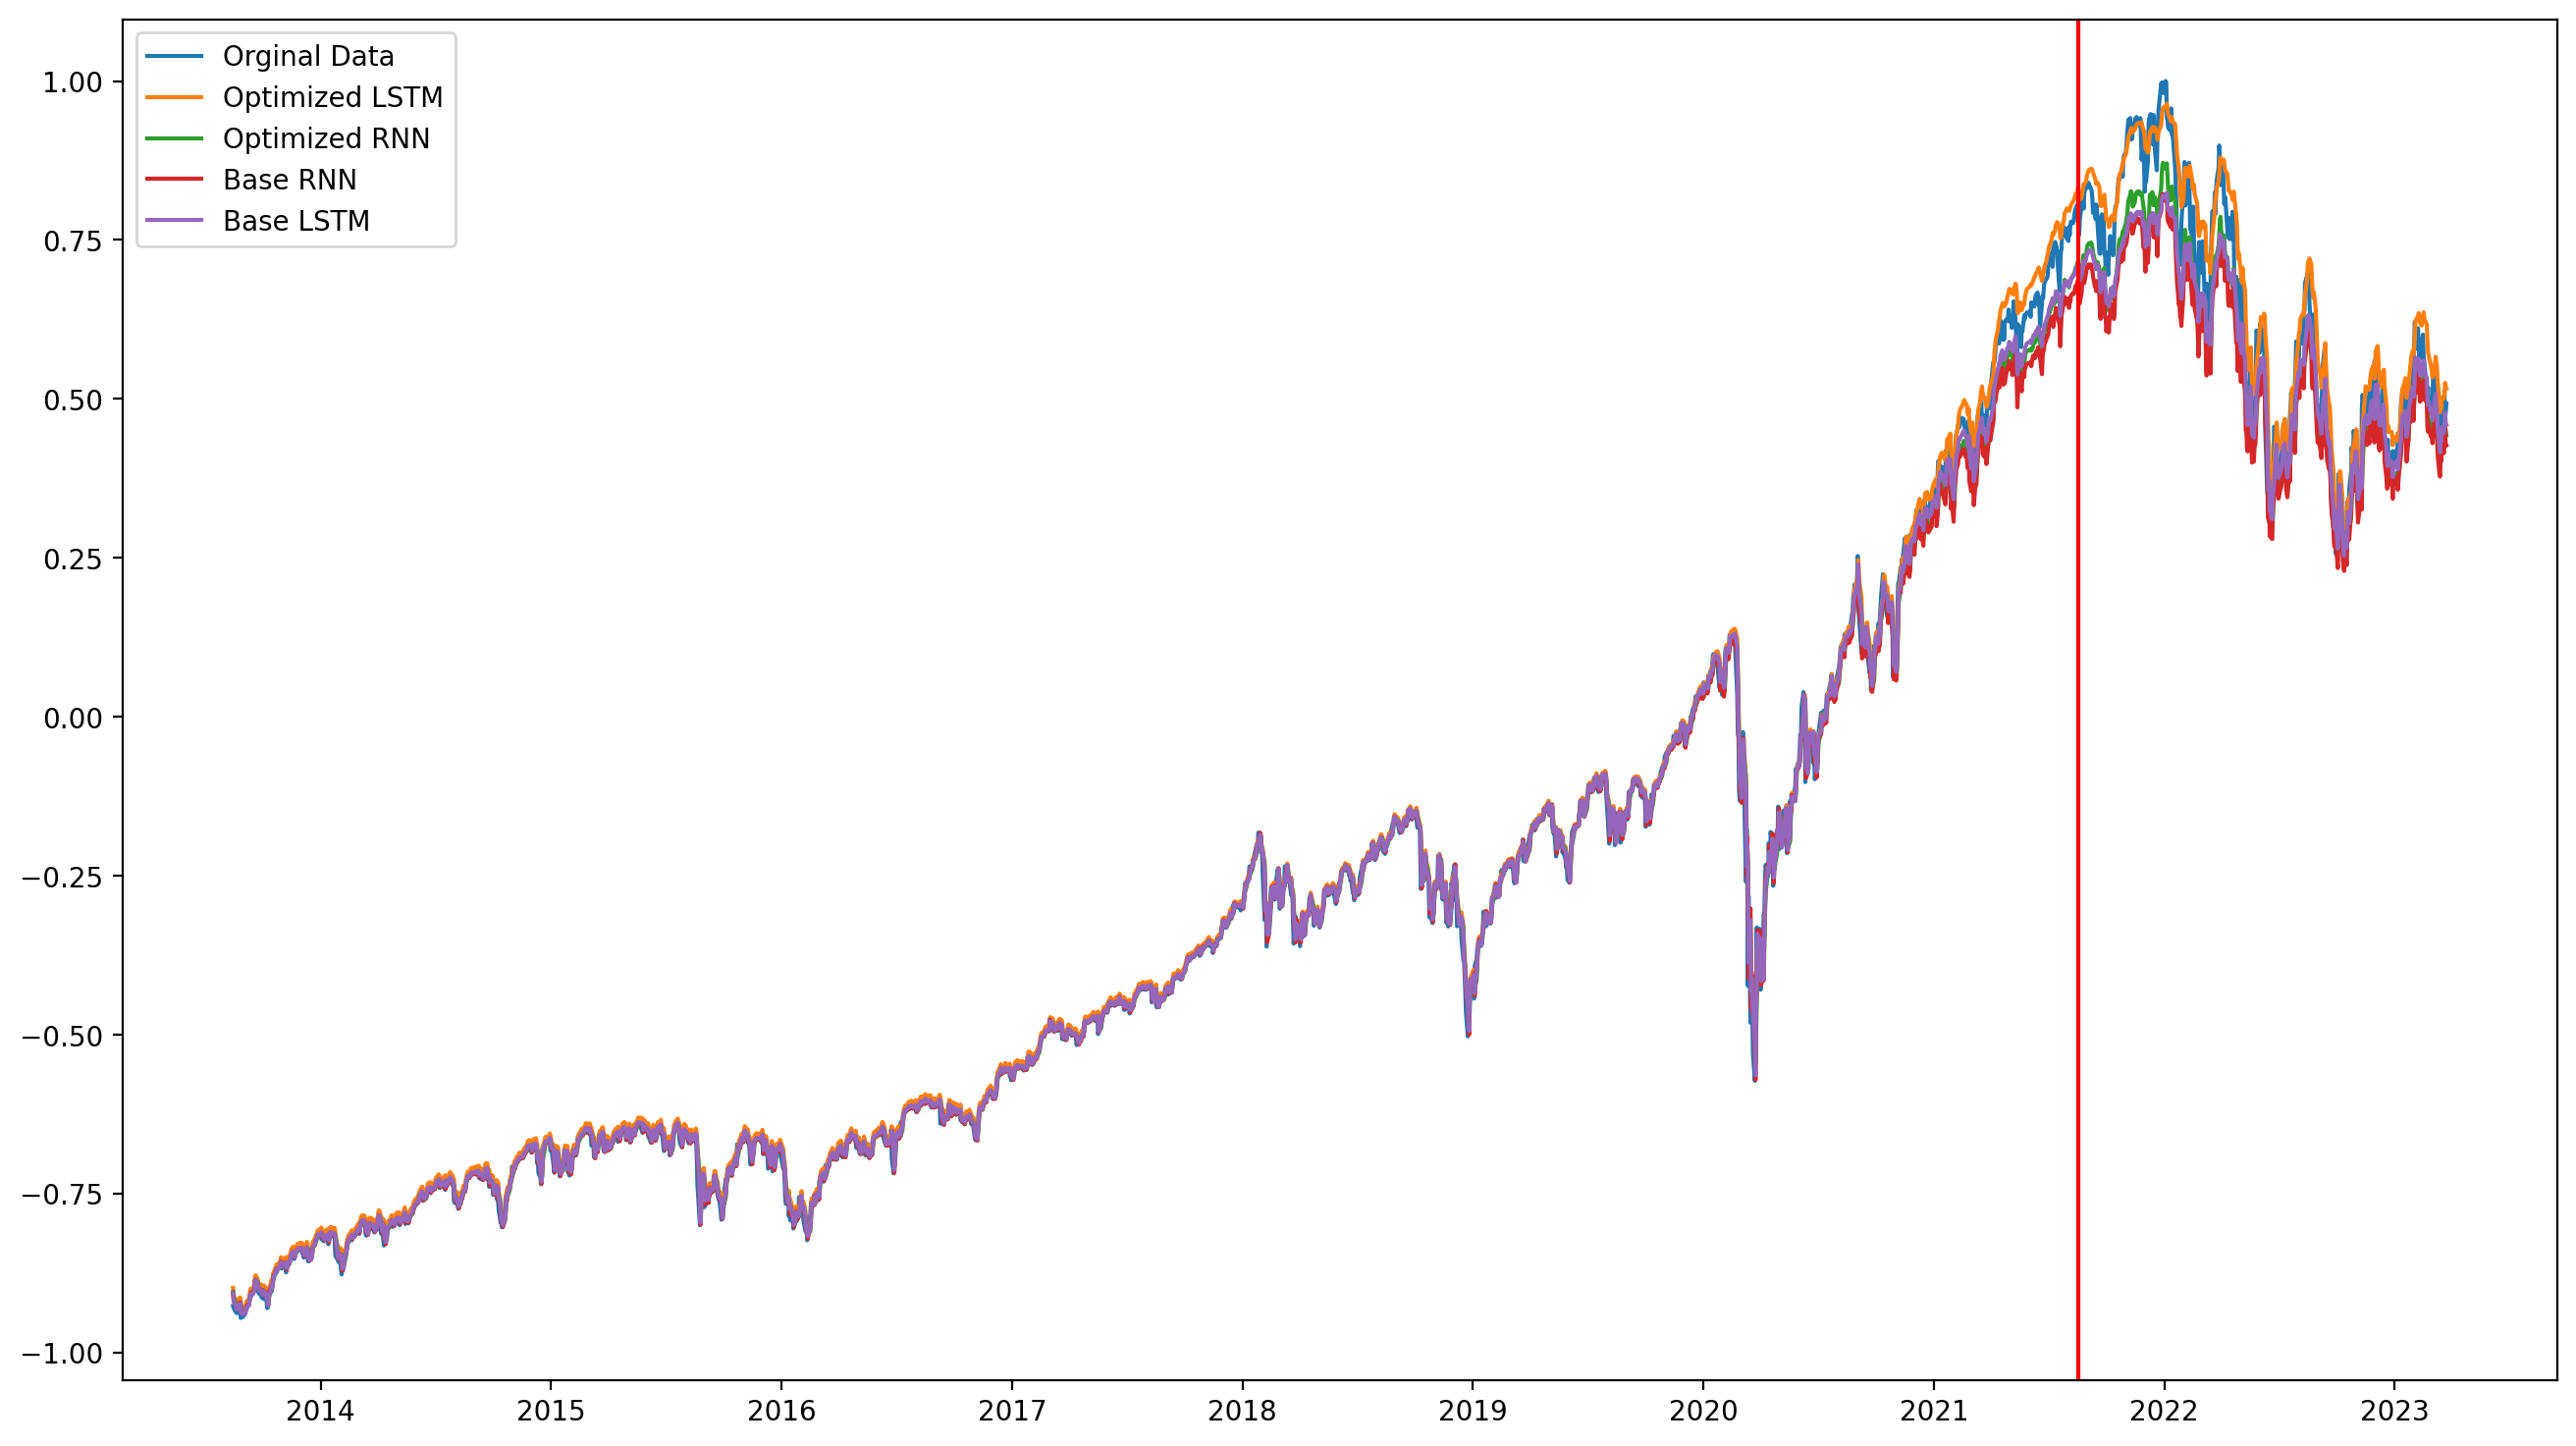

In [377]:
all_data_features, all_data_target = create_testing_data(raw_data, 100)
best_lstm_pred = best_trained_lstm(all_data_features).detach().numpy()
best_rnn_pred = best_trained_rnn(all_data_features).detach().numpy()
base_rnn_pred = rnn_model_1(all_data_features).detach().numpy()
base_lstm_pred = lstm_model_1(all_data_features).detach().numpy()

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(stock_data.index[100:], all_data_target.detach().numpy())
plt.plot(stock_data.index[100:], best_lstm_pred)
plt.plot(stock_data.index[100:], best_rnn_pred)
plt.plot(stock_data.index[100:], base_rnn_pred)
plt.plot(stock_data.index[100:], base_lstm_pred)
plt.axvline(stock_data.index[int(0.8*len(raw_data)+100):int(0.8*len(raw_data))+1+100], color='r')
plt.legend(['Orginal Data', 'Optimized LSTM', 'Optimized RNN', 'Base RNN', 'Base LSTM'])

## Save Model for testing

In [378]:
torch.save(best_trained_rnn.state_dict(), 'best_rnn.pth')
torch.save(best_trained_lstm.state_dict(), 'best_lstm.pth')

Test if the files can be loaded back

In [379]:
test_rnn = RNN(hidden_dim=50, num_layers=2)
test_rnn.load_state_dict(torch.load('best_rnn.pth'))
test_rnn(X_test)

tensor([[ 0.0533],
        [ 0.0575],
        [ 0.0634],
        [ 0.0666],
        [ 0.0678],
        [ 0.0771],
        [ 0.0881],
        [ 0.0909],
        [ 0.0895],
        [ 0.0891],
        [ 0.0807],
        [ 0.0582],
        [ 0.0523],
        [ 0.0566],
        [ 0.0629],
        [ 0.0499],
        [ 0.0412],
        [ 0.0565],
        [ 0.0822],
        [ 0.1005],
        [ 0.1003],
        [ 0.1007],
        [ 0.1053],
        [ 0.1147],
        [ 0.1202],
        [ 0.1221],
        [ 0.1198],
        [ 0.1214],
        [ 0.1209],
        [ 0.1084],
        [ 0.0656],
        [ 0.0043],
        [-0.0327],
        [-0.0813],
        [-0.1210],
        [-0.0925],
        [-0.0822],
        [-0.0541],
        [-0.0590],
        [-0.0993],
        [-0.1894],
        [-0.2148],
        [-0.2333],
        [-0.3335],
        [-0.3382],
        [-0.3960],
        [-0.4209],
        [-0.4386],
        [-0.4645],
        [-0.4973],
        [-0.5462],
        [-0.5079],
        [-0.